<br></br>
# **나이브베이즈 한글 적용**
nltk를 활용한 네이버 영화리뷰 평가모델 [nltk book](https://www.nltk.org/book/ch06.html) | [nltk How to](http://www.nltk.org/howto/classify.html)
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [1]:
# ! cat ./data/ratings_test.txt | head -n 10

In [2]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/20)) ]
    return random_data

In [3]:
train_data = read_data('./data/ratings_train.txt')
test_data  = read_data('./data/ratings_test.txt')

print('Train_data ({})\nsample : {}\nTest_data  ({})\nsample : {}'.format(
    len(train_data), train_data[:3],
    len(test_data),  test_data[:3]))

Train_data (7500)
sample : [['6253952', '평점 높게 준 사람들 분명 7광구는 희대의역작이라 평가했을거다..-_-ㅋ', '0'], ['9673883', '과연 믿고 보는 기타노 다케시', '1'], ['7698357', '삶을 바라보는 눈과 태도에 대한 깨알같은 명언과 조언들...완벽한 레시피로 이루어낸 귀염성과 멋진 액션의 조화 ㅎㅎ 눈이 즐겁다 ㅎㅎ', '1']]
Test_data  (2500)
sample : [['9029909', '감독님. 촌스러움의 미학이라니, 이게 어찌 촌스럽습니까', '1'], ['6316333', '무신 나오면서부터 OO력의 끝장을보여줌 장면하나하나가 장애끼 폭발한다', '0'], ['9022506', '후덜덜잘좀 공감하면서보세여ㅡㅡ 내가 저상황에 저리 홀린듯 뺑뺑 돌면 울고 불고 미친듯이 욕하고ㅡㅡ 하지 무서워서 ㅉㅉ 영화볼지를 모르네', '1']]


In [4]:
%%time
from konlpy.tag import Twitter
twitter = Twitter()

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['평점/Noun',
   '높다/Adjective',
   '준/Noun',
   '사람/Noun',
   '들/Suffix',
   '분명/Noun',
   '7/Number',
   '광구/Noun',
   '는/Josa',
   '희다/Adjective',
   '대의/Noun',
   '역작/Noun',
   '이라/Josa',
   '평가/Noun',
   '하다/Verb',
   '..-_-/Punctuation',
   'ㅋ/KoreanParticle'],
  '0'),
 (['과연/Noun', '믿다/Verb', '보다/Verb', '기타/Noun', '노/Noun', '다케시/Noun'], '1')]
CPU times: user 19.4 s, sys: 156 ms, total: 19.5 s
Wall time: 12.6 s


In [5]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:5]))

Token Total :109112
Sample : ['평점/Noun', '높다/Adjective', '준/Noun', '사람/Noun', '들/Suffix']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [6]:
import nltk
text = nltk.Text(tokens, name='NMSC')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common(5))    

number of Token : 109112 
unique Token    : 10908

[('./Punctuation', 3475),
 ('영화/Noun', 2587),
 ('하다/Verb', 2423),
 ('이/Josa', 1923),
 ('보다/Verb', 1683)]


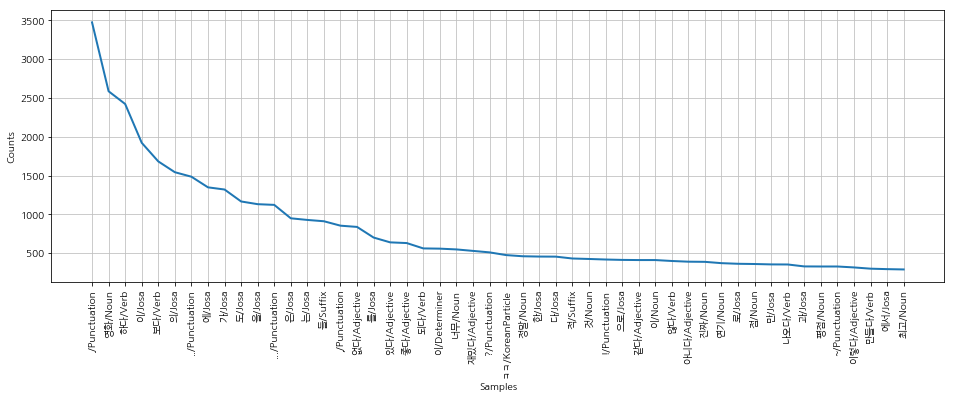

In [7]:
%matplotlib inline
from matplotlib import rc
rc('font', family=['NanumGothic','Malgun Gothic'])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot(50) 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [8]:
# 검색가능 단어목록 추출하기
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '이/Josa', '보다/Verb']

In [9]:
# Mission 1
# selected 객체를 './data/selected.words' 로 저장하기
import pickle
pickle.dump(selected_words, open('./data/selected.words', 'wb'))

In [10]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 35.1 s, sys: 1.39 s, total: 36.5 s
Wall time: 36.4 s


In [11]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 34.7 s, sys: 6.9 ms, total: 34.8 s
Wall time: 34.8 s


In [12]:
# Mission 2
# classifiers 객체를 './data/classifiers.model' 로 저장하기
import pickle
pickle.dump(classifiers, open('./data/classifiers.model', 'wb'))

<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [13]:
%%time
import pickle
# 학습한 모델객체 저장하기
# Google 에 찾아보기 : Python classifier Save

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [14]:
classifiers.labels()

['0', '1']

In [15]:
classifiers.show_most_informative_features(20)

Most Informative Features
         exists(어이/Noun) = True                0 : 1      =     27.6 : 1.0
         exists(알바/Noun) = True                0 : 1      =     21.7 : 1.0
         exists(강추/Noun) = True                1 : 0      =     21.6 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     20.9 : 1.0
  exists(재미없다/Adjective) = True                0 : 1      =     16.8 : 1.0
   exists(아깝다/Adjective) = True                0 : 1      =     16.3 : 1.0
          exists(굿/Noun) = True                1 : 0      =     14.8 : 1.0
  exists(따뜻하다/Adjective) = True                1 : 0      =     14.6 : 1.0
         exists(대해/Noun) = True                1 : 0      =     14.1 : 1.0
    exists(뭔/NounPrefix) = True                0 : 1      =     13.9 : 1.0
        exists(차라리/Noun) = True                0 : 1      =     13.8 : 1.0
         exists(막장/Noun) = True                0 : 1      =     13.0 : 1.0
         exists(여운/Noun) = True                1 : 0      =     12.5 : 1.0

In [16]:
%%time
'네이버 긍부정 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 25.4 s, sys: 11.3 ms, total: 25.4 s
Wall time: 25.4 s


'네이버 긍부정 모델의 Accuracy : 0.7992'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [21]:
review = """졸잼 굿 최고입니다 최고"""

In [22]:
# 리뷰 데이터를 Tagged Token 생성하기
review = tokenize(review)    
review

['졸잼/Noun', '굿/Noun', '최고/Noun', '이다/Adjective', '최고/Noun']

In [23]:
# Tagged Token 중 selected_words 포함여부 판단
review = term_exists(review) 
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(최고/Noun) = True
exists(이다/Adjective) = True
exists(굿/Noun) = True


In [24]:
result = classifiers.classify(review)  # 분류모델 평가
if result == '1': print('긍정리뷰')
else:             print('부정리뷰')

긍정리뷰
